In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Bottom Up 1e-2', 'Bottom Up 1e-4', 'Bottom Up 1e-6', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up 1e-0', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Bottom Up 1e-10', 'Top Down', 'Top Down 1e-0']
(900, 14)
['Top Down (only last)' 'Without simplif

model
Bottom Up                 -7.57 \pm 83.63
Bottom Up (only last)    -14.72 \pm 82.07
Top Down                 -10.10 \pm 90.65
Top Down (only last)     -12.92 \pm 85.35
Without simplify            0.00 \pm 0.00
dtype: object

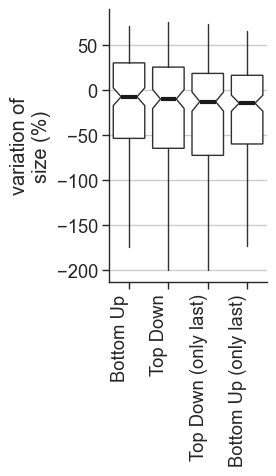

model
Bottom Up                 -5.07 \pm 113462.12
Bottom Up (only last)    -96.33 \pm 293153.87
Top Down                 -50.89 \pm 774091.27
Top Down (only last)     -58.10 \pm 543849.87
Without simplify                0.00 \pm 0.00
dtype: object

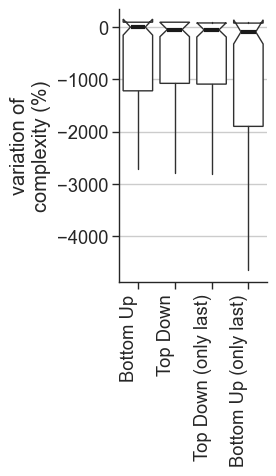

model
Bottom Up                -0.17 \pm 106.42
Bottom Up (only last)     -0.25 \pm 49.79
Top Down                 -0.27 \pm 169.06
Top Down (only last)     -0.18 \pm 215.46
Without simplify            0.00 \pm 0.00
dtype: object

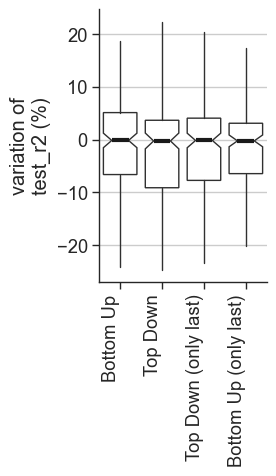

model
Bottom Up                4.70 \pm 91.93
Bottom Up (only last)    3.22 \pm 71.66
Top Down                 8.00 \pm 66.02
Top Down (only last)     3.95 \pm 79.35
Without simplify          0.00 \pm 0.00
dtype: object

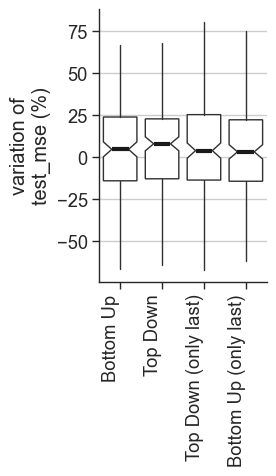

In [2]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplify'].groupby(['dataset', 'random_state']))

for metric in ['size', 'complexity', 'test_r2', 'test_mse']:
    speeds    = []
    for (model, dataset, random_state), group_df in \
        results_df.loc[results_df['model'] != 'Baseline'].groupby(['model', 'dataset', 'random_state']):
        # 'contextual' is used as a hue in the plots

        baseline_curve = baseline_convergence.get_group((dataset, random_state))
        
        metric_baseline = baseline_curve[metric].values[0]
        metric_model = group_df[metric].values[0]
        speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

    speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])

    display(speeds_df.groupby(['model'])
            .agg(['median','std'])
            .applymap(lambda x: '{0:.2f}'.format(x))
            .agg(r' \pm '.join, axis=1)
            )
    
    g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
        #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
        legend_out=False, aspect=0.6,
        order = [o for o in order if o != 'Without simplify'], # The first is Baseline
        **boxplot_kwargs, sharey=False
    )

    # g.set(yscale="log")

    g.set_titles("{col_name}").set_axis_labels("", f"variation of\n{metric} (%)")

    # iterate through each subplot / Facet
    single_plot = True
    for (ds, plot_ax) in g._axes_dict.items():
        single_plot = False
        plot_ax.grid(which='major', axis='y', linewidth=1)
        #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        # Contextual vs non-contextual
        pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

        if False:
            annotator = Annotator(
                plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
                x='model', y='Speed up',
                order=order[1:])
            annotator.reset_configuration()
            annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
            
            # Calculate and annotate
            annotator.apply_and_annotate()
            
    if single_plot: 
        g.ax.grid(which='major', axis='y', linewidth=1)
        #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in g.ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/delta_{metric}.pdf")
    plt.savefig(f"../paper/figs/delta_{metric}.png")
    plt.show()